In [12]:
import os
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
import autograd.numpy as npa

from matplotlib import pyplot as plt
import h5py as hp
import pint
from icecream import ic
from skimage.segmentation import find_boundaries

ur = pint.UnitRegistry()

1.25.0-beta


In [13]:
def trouver_centres(vecteur):
    vecteur = (vecteur - vecteur.min())/(vecteur.max() - vecteur.min())
    indices_uns = np.where(vecteur == 1)[0]
    changements = np.where(np.diff(indices_uns) != 1)[0]
    centre1 = indices_uns[0] + (indices_uns[changements[0]] - indices_uns[0]) // 2
    centre2 = indices_uns[changements[0] + 1] + (indices_uns[-1] - indices_uns[changements[0] + 1]) // 2
    return centre1, centre2

In [14]:
def double_with_mirror(image):
    channels = '~/scratch/nanophoto/lowfom/nodata/fields/channels.npy'
    channels = np.load(os.path.expanduser(channels))
    mirrored_image = np.fliplr(image)  # Crée l'image miroir
    doubled_image = np.concatenate((mirrored_image[:, :-1], image), axis=1)
    return doubled_image

def get_channels():
    return np.load(os.path.join(PATH, 'channels.npy'))

def double_and_add_channels(image):
    double = double_with_mirror(image)
    full_device = get_channels()
    full_device[44: 145, 12:193] = double
    return full_device

def set_experiment_indices(image):
    channels = get_channels()
    indmin = channels.min()
    indmax = channels.max()
    assert image.min() == 0 and image.max() == 1
    image = image*(indmax - indmin) + indmin
    return image

def normalise(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image


## Basic environment setup

In [15]:
lum_waveguide_len, lum_waveguide_wid = (44, 25)
lum_waveguide_len = lum_waveguide_len*ur.pixel
lum_waveguide_wid = lum_waveguide_wid*ur.pixel

In [16]:
# Lumerical experiment setup
# Dimensions definition
# < Length of the device (in nm). Longer devices typically lead to better performance
size_x = 2000*ur.nanometer
delta_x = 20*(ur.nanometer/ur.pixels)  # < Size of a pixel along x-axis (in nm)
# < Since we use symmetry, this is only have the extent along the y-axis (in nm)
size_y = 1800*ur.nanometer
delta_y = delta_x  # < Size of a pixel along y-axis (in nm)
# < Radius of the smoothing filter which removes small features and sharp corners (in nm)
filter_R = 200*ur.nanometer
# < Effective permittivity for a Silicon waveguide with a thickness of 220nm
eps_max = 2.8 ** 2
eps_min = 1.44 ** 2  # < Permittivity of the SiO2 cladding
x_points = (int((size_x / delta_x).magnitude)*ur.pixel + 1*ur.pixel)
y_points = (int((size_y / delta_y).magnitude)*ur.pixel + 1*ur.pixel)
x_pos = np.linspace(-size_x.magnitude / 2, size_x.magnitude / 2, x_points.magnitude) * 1e-9
y_pos = np.linspace(0, size_y.magnitude, y_points.magnitude) * 1e-9
lum_source_wavelength = 1550*ur.nanometer
lum_arm_sep = (125)*ur.pixel

In [17]:
seed = 240
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=2.88) # Effective permittivity for a Silicon waveguide with a thickness of 220nm
SiO2 = mp.Medium(index=1.44)
delta = delta_x.to(ur.micrometers/ur.pixel) #(0.02)*ur.micrometers  size of a pixel (in μm) 20 nm in lumerical exp
# resolution = 20 # (pixels/μm)
resolution = 1/delta # pixels/μm
waveguide_width = (delta_y * lum_waveguide_wid).to(ur.micrometer) #0.5 # (μm)
design_region_width = size_x.to(ur.micrometer)  + delta*ur.pixel # (μm)
design_region_height = (2*size_y).to(ur.micrometer) + delta*ur.pixel # (μm)
arm_separation = (lum_arm_sep*delta_y).to(ur.micrometer) #1.0  (μm) distance between arms center to center
waveguide_length = (lum_waveguide_len*delta).to(ur.micrometer) #0.5  (μm)
pml_size = 1.0 # (μm)


In [18]:
ic(resolution, waveguide_length, waveguide_width, design_region_height, design_region_width, arm_separation)

ic| resolution: <Quantity(50.0, 'pixel / micrometer')>
    waveguide_length: <Quantity(0.88, 'micrometer')>
    waveguide_width: <Quantity(0.5, 'micrometer')>
    design_region_height: <Quantity(3.62, 'micrometer')>
    design_region_width: <Quantity(2.02, 'micrometer')>
    arm_separation: <Quantity(2.5, 'micrometer')>


(<Quantity(50.0, 'pixel / micrometer')>,
 <Quantity(0.88, 'micrometer')>,
 <Quantity(0.5, 'micrometer')>,
 <Quantity(3.62, 'micrometer')>,
 <Quantity(2.02, 'micrometer')>,
 <Quantity(2.5, 'micrometer')>)

In [19]:
delta = delta.magnitude
resolution = resolution.magnitude
waveguide_width = waveguide_width.magnitude
design_region_width = design_region_width.magnitude
design_region_height = design_region_height.magnitude
arm_separation = arm_separation.magnitude
waveguide_length = waveguide_length.magnitude

## Design variable setup

In [20]:
minimum_length = 0.09 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)
eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) #int(4*resolution) # (pixels/μm)
frequencies = 1/np.linspace(1.5,1.6,5) # (1/μm)

Nx = int(design_region_resolution*design_region_width)
Ny = int(design_region_resolution*design_region_height)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si)
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_width, design_region_height)))

Nx, Ny

(101, 181)

## Simulation Setup

In [26]:
Sx = 2*pml_size + 2*waveguide_length + design_region_width # cell size in X
Sy = 2*pml_size + design_region_height + 0.5 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = (1/lum_source_wavelength.to(ur.micrometer)).magnitude #1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-Sx/2 + pml_size + waveguide_length/3,0,0]
source_size = mp.Vector3(0,waveguide_width, 0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                            eig_band=1,
                            direction=mp.NO_DIRECTION,
                            eig_kpoint=kpoint,
                            size=source_size,
                            center=source_center,
                            eig_parity=mp.ODD_Z+mp.EVEN_Y)]

# source = [mp.Source(mp.ContinuousSource(frequency=0.15,
#                                         end_time=100),
#                     component=mp.Ez,
#                     center=mp.Vector3(*source_center),
#                     size=source_size)]


geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # left waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=Sx/4, y=-arm_separation/2), material=Si, size=mp.Vector3(Sx/2+1, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

## Design parameter mapping

In [22]:
def mapping(x,eta,beta):
    # eta in [0,1], skews the distribution towards one material or the other?
    # higher beta makes design more binarized
    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    # filter
    filtered_field = mpa.conic_filter(x,
        filter_radius,design_region_width,design_region_height,design_region_resolution)
    # projection
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)
    # interpolate to actual materials
    return projected_field.flatten()

ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -7.466222149449502e-06, f0.max(): 7.538955028417417e-06
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -1.3188063905758064e-05
    f0.max(): 1.3188063919167268e-05
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -9.07171698664247e-06, f0.max(): 9.65003419524679e-06
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0


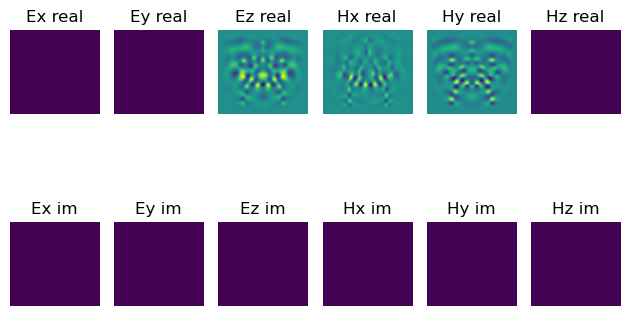

ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -7.466222149449502e-06, f0.max(): 7.538955028417417e-06
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -1.3188063905758064e-05
    f0.max(): 1.3188063919167268e-05
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -9.07171698664247e-06, f0.max(): 9.65003419524679e-06
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0


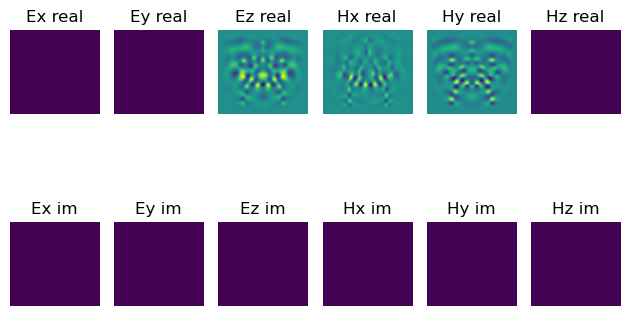

ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -7.466222149449502e-06, f0.max(): 7.538955028417417e-06
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -1.3188063905758064e-05
    f0.max(): 1.3188063919167268e-05
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): -9.07171698664247e-06, f0.max(): 9.65003419524679e-06
ic| f1.min(): 0.0, f1.max(): 0.0
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0


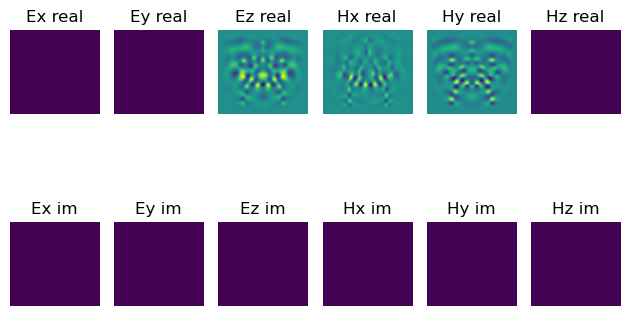

In [ ]:
kz_2d_list = ["3d", "complex", "real/imag"]
for kz_2d in kz_2d_list:
    sim = mp.Simulation(cell_size=cell_size,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        sources=source,
                        #symmetries=[mp.Mirror(direction=mp.Y)],
                        kz_2d=kz_2d,
                        default_material=SiO2,
                        resolution=resolution)

    PATH = os.path.expanduser('~/scratch/nanophoto/lowfom/nodata/fields/')
    # PATH = os.path.expanduser('~/scratch/nanophoto/highfom/')
    image_idx = 1
    image = np.load(os.path.join(PATH, 'images.npy'))[image_idx]
    idx_map = double_with_mirror(image)
    idx_map = normalise(idx_map)
    index_map = mapping(idx_map, 0.5, 256)
    design_region.update_design_parameters(index_map)
    sim.plot2D()

    mon_pt = mp.Vector3(*source_center)
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt,
                                                                1e-9))
    
    _, axes = plt.subplots(2,6)
    names = ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz']
    for i, component in enumerate([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz]):
        field = sim.get_array(component=component, cmplx=True)
        f0 = np.real(field)
        f1 = np.imag(field)
        axes[0,i].imshow(f0)
        axes[0,i].set_title(f'{names[i]} real')
        axes[0,i].axis('off')
        axes[1,i].imshow(f1)
        axes[1,i].axis('off')
        axes[1,i].set_title(f'{names[i]} im')
        ic(f0.min(), f0.max())
        ic(f1.min(), f1.max())
    plt.tight_layout()
    plt.show()

ic| f0.min(): -0.6147139150878218, f0.max(): 0.6147139150878218
ic| f1.min(): -0.5862201920114011, f1.max(): 0.5862201920114011
ic| f0.min(): -1.0657774119307353, f0.max(): 1.299933493997433
ic| f1.min(): -0.9230115798233446, f1.max(): 1.1151629425060283
ic| f0.min(): 0.0, f0.max(): 0.0
ic| f1.min(): 0.0, f1.max(): 0.0


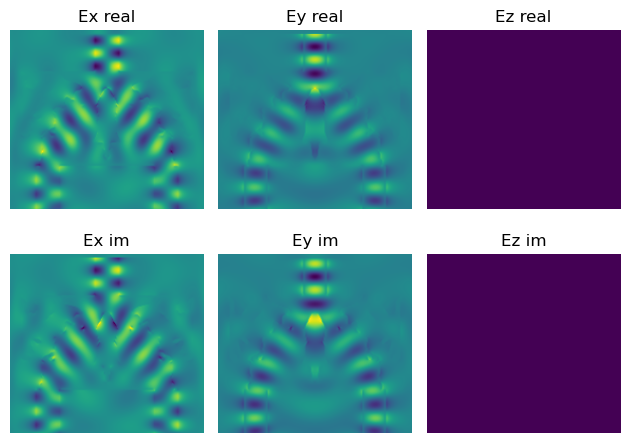

In [24]:


field = np.load(os.path.join(PATH, 'fields.npy'))[image_idx]
names = ['Ex', 'Ey', 'Ez']
_, axes = plt.subplots(2,len(names))
for i, name in enumerate(names):
    f0 = np.real(field[...,i])
    f1 = np.imag(field[...,i])
    axes[0,i].imshow(f0)
    axes[0,i].set_title(f'{name} real')
    axes[0,i].axis('off')
    axes[1,i].imshow(f1)
    axes[1,i].axis('off')
    axes[1,i].set_title(f'{name} im')
    ic(f0.min(), f0.max())
    ic(f1.min(), f1.max())
plt.tight_layout()
plt.show()